딥러닝 파이토치 교과서 ch7. 6 ~7 p.417 ~440

### **[개념 정리+코드 필사]📝**

### **7.6 게이트 순환 신경망(GRU)**

7.6.1 GRU 구조
- LSTM의 망각게이트+입력게이트, 별도의 업데이트 게이트
  -게이트 컨트롤러: 망각게이트+입력게이트 모두 제어. 이전 기억이 저장될 때마다 단계별 입력은 삭제
  - 출력게이트X: 전체 상태 벡터가 매 단계마다 출력. 출력되는 부분은 컨트롤러가 존재
- ✅ 망각게이트: 과거 정보를 적당히 초기화(시그모이드 함수 이용)
- ✅ 업데이트 게이트: 과거와 현재 정보의 최신화 비율을 결정(시그모이드 이용)
- 후보군: 현시점 정보에 대한 후보군 계산. 망각게이트의 결과를 이용
- 은닉층 계산: 업데이트 게이트 결과_후보군 결과 -> 현시점의 은닉층 계산.(시그모이드 결과=현시점의 정보량)

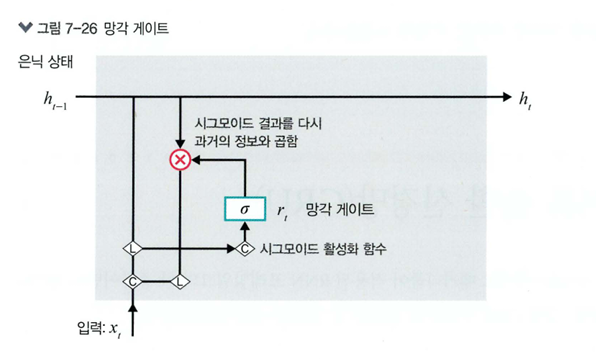

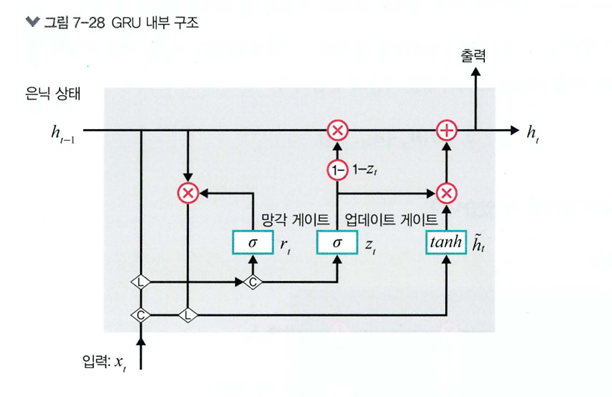

7.6.2 GRU 셀 구현

- LSTM 셀과 동일하나 네트워크의 차이
- MNIST 데이터셋 사용
  - 데이터셋 정규화, 텐서로 변경
  - 데이터로더로 메모리 불러오기

In [18]:
# 라이브러리 호출
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn .functional as F
from torch.utils.data import DataLoader
import math

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
torch.manual_seed(125)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(125)

In [19]:
# 데이터 전처리
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(1.0,))
])

In [20]:
# 데이터셋 내려받기 및 전처리 적용
from torchvision.datasets import MNIST
download_root = '../chap07/MNIST_DATASET'
train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True )
valid_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True )
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True )

In [21]:
# 데이터셋 메모리로 가져오기
batch_size = 64
train_loader = DataLoader(dataset = train_dataset,
                          batch_size = batch_size,
                          shuffle = True)
valid_loader = DataLoader(dataset = test_dataset,
                          batch_size = batch_size,
                          shuffle = True)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=True )

In [22]:
# 변수 값 설정
batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(train_dataset)/batch_size)
num_epochs = int(num_epochs)

- GRU 셀 네트워크
  - LSTM과 달리 세 개의 게이트 이므로  nn.Linear(input_size, 3*hidden_size, bias = bias) 3을 곱합
  

In [23]:
class GRUCell(nn.Module):
  def __init__(self, input_size, hidden_size, bias = True):
    super(GRUCell, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias
    self.x2h = nn.Linear(input_size, 3*hidden_size, bias = bias)
    self.h2h = nn.Linear(hidden_size, 3*hidden_size, bias=bias)
    self.reset_parameters()

  def reset_parameters(self): # 파라미터 초기화
    std = 1.0 / math.sqrt(self.hidden_size)
    for w in self.parameters():
      w.data.uniform_(-std, std)

  def forward(self, x, hidden):
    x = x.view(-1, x.size(1))
    gate_x = self.x2h(x)
    gate_h = self.h2h(hidden)
    gate_x = gate_x.squeeze()
    gate_h = gate_h.squeeze()

    i_r, i_i, i_n = gate_x.chunk(3,1)
    h_r, h_i, h_n = gate_h.chunk(3,1)

    resetgate = F.sigmoid(i_r+h_r)
    inputgate = F.sigmoid(i_r + h_i)
    newgate = F.tanh(i_n + (resetgate*h_n))

    hy = newgate + inputgate*(hidden-newgate)
    return hy

In [24]:
# 전반적 네트워크 구조
class GRUModel (nn .Module ):
  def __init__(self, input_dim , hidden_dim, layer_dim, output_dim, bias=True):
    super(GRUModel, self).__init__()
    self.hidden_dim = hidden_dim
    self.layer_dim = layer_dim
    self.gru_cell = GRUCell(input_dim, hidden_dim, layer_dim)
    self.fc = nn.Linear(hidden_dim, output_dim )
  def forward(self, x):
    if torch.cuda.is_available():
      h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
    else:
      h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

    outs = []
    hn = h0[0,:,:]
    for seq in range(x.size(1)):
      hn = self.gru_cell(x[: ,seq,:], hn )
      outs.append(hn)
      out = outs[-1].squeeze()
      out = self.fc(out )
      return out

In [25]:
# 옵티마이저와 손실 함수 설정
input_dim = 28
hidden_dim = 128
layer_dim = 1
output_dim = 10

model = GRUModel(input_dim, hidden_dim, layer_dim, output_dim)

if torch.cuda.is_available():
  model.cuda()

criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

- 모델 학습 성능 - LSTM과 정확도 유사. 시계열 관련 모델은 데이터셋마다 최적의 모델이 다름
  - 다양한 모델 적용, 최적 하이퍼파라미터 찾는것이 중요

In [26]:
# 모델 학습 및 성능 검증
seq_dim = 28
loss_list = []
iter = 0
for epoch in range (num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    if torch.cuda.is_available():
      images = Variable(images.view(-1, seq_dim, input_dim).cuda())
      labels = Variable(labels.cuda())
    else:
      images = Variable(images .view(-1, seq_dim, input_dim))
      labels = Variable(labels )
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs,labels)

    if torch.cuda .is_available():
      loss.cuda()
    loss .backward()
    optimizer.step()
    loss_list.append (loss.item())
    iter += 1

    if iter % 500 == 0:
      correct = 0
      total = 0
      for images, labels in valid_loader:
        if torch.cuda.is_available():
          images = Variable(images.view(-1 , seq_dim, input_dim).cuda())
        else:
          images = Variable(images.view(-1 , seq_dim, input_dim))
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        if torch.cuda.is_available():
          correct += (predicted.cpu() -- labels.cpu()) .sum()
        else:
          correct += (predicted == labels).sum()
      accuracy = 100 * correct / total
      print( 'Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.3020079135894775. Accuracy: 10.319999694824219
Iteration: 1000. Loss: 2.310201406478882. Accuracy: 11.350000381469727
Iteration: 1500. Loss: 2.3060927391052246. Accuracy: 11.350000381469727
Iteration: 2000. Loss: 2.3005635738372803. Accuracy: 11.350000381469727
Iteration: 2500. Loss: 2.292823076248169. Accuracy: 11.350000381469727
Iteration: 3000. Loss: 2.3091325759887695. Accuracy: 11.350000381469727
Iteration: 3500. Loss: 2.305866241455078. Accuracy: 11.350000381469727
Iteration: 4000. Loss: 2.304656744003296. Accuracy: 11.350000381469727
Iteration: 4500. Loss: 2.3079142570495605. Accuracy: 11.350000381469727
Iteration: 5000. Loss: 2.2947776317596436. Accuracy: 11.350000381469727
Iteration: 5500. Loss: 2.2990429401397705. Accuracy: 11.350000381469727
Iteration: 6000. Loss: 2.3024885654449463. Accuracy: 11.350000381469727
Iteration: 6500. Loss: 2.3102309703826904. Accuracy: 11.350000381469727
Iteration: 7000. Loss: 2.313585042953491. Accuracy: 11.35000038146972

In [27]:
# 테스트 데이터셋을 이용한 모델 예측
def evaluate(model, val_iter):
  corrects, total, total_loss = 0, 0, 0
  model.eval()
  for images, labels in val_iter:
    if torch.cuda.is_available():
      images = Variable(images.view(-1, seq_dim, input_dim).cuda())
    else:
      images = Variable(images.view(-1, seq_dim, input_dim)).to(device)
    logit = model(images).to(device)
    loss = F.cross_entropy(logit, labels, reduction="sum")
    _, predicted = torch.max(logit.data, 1)
    total += labels.size(0)
    total_loss += loss.item()
    corrects += (predicted == labels).sum()
  avg_loss = total_loss / len(val_iter.dataset)
  avg_accuracy = corrects / total
  return avg_loss, avg_accuracy

In [28]:
test_loss, test_acc = evaluate(model, test_loader)
print("Test Loss: %5.2f, Test Accuracy: %5.2f"% (test_loss, test_acc))

Test Loss:  2.30, Test Accuracy:  0.11


7.6.3 GRU 계층 구현

In [48]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch .utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn .preprocessing import StandardScaler, MinMaxScaler
from sklearn .model_selection import train_test_split

device = torch.device( 'cuda:0' if torch.cuda.is_available() else 'cpu')

In [49]:
# 데이터셋 불러오기
data = pd.read_csv('/content/drive/MyDrive/ESAA/OB 과제/SBUX.csv')
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [50]:
# 인덱스 설정 및 데이터 타입 변경
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Volume'] = data['Volume'].astype(float)

In [51]:
# 훈련과 레이블 데이터셋 분리
X = data.iloc[:, :-1]
y = data.iloc[:, 5:6]
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [52]:
# 훈련과 테스트 데이터
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss [:200, : ]
X_test = X_ss [200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:,:]

print('Training Shape', X_train.shape, y_train.shape)
print('Testing Shape', X_test.shape, y_test.shape)

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


In [53]:
# 데이터셋 형태 변경 -> LSTM에 적용 위함
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))
y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0],
                                                    1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0],
                                                    1, X_test_tensors.shape[1]))

print ("Training Shape" , X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape" , X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [54]:
# GRU 모델의 네트워크
class GRU(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(GRU, self).__init__()
    self.num_classes = num_classes
    self.num_layers = num_layers
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.seq_length = seq_length

    self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.fc_1 = nn.Linear(hidden_size, 128)
    self.fc = nn.Linear(128, num_classes)
    self.relu = nn.ReLU()

  def forward(self, x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
    output, (hn) = self.gru(x, (h_0))
    hn = hn.view(-1, self.hidden_size)
    out = self.relu(hn)
    out = self.fc_1(out)
    out = self.relu(out)
    out = self.fc(out)
    return out

In [55]:
# 옵티마이저 손실 함수 지정
num_epochs = 1000
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers = 1 # GRU 계층의 개수

num_classes = 1
model = GRU(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [60]:
# 모델 학습
for epoch in range(num_epochs):
  outputs = model.forward(X_train_tensors_f)
  optimizer.zero_grad()
  loss = criterion(outputs, y_train_tensors)
  loss.backward()

  optimizer.step()
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.02987
Epoch: 100, loss: 0.02796
Epoch: 200, loss: 0.02606
Epoch: 300, loss: 0.02414
Epoch: 400, loss: 0.02236
Epoch: 500, loss: 0.02084
Epoch: 600, loss: 0.01950
Epoch: 700, loss: 0.01871
Epoch: 800, loss: 0.01832
Epoch: 900, loss: 0.01815


In [61]:
# 그래프 출력을 위한 전처리
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

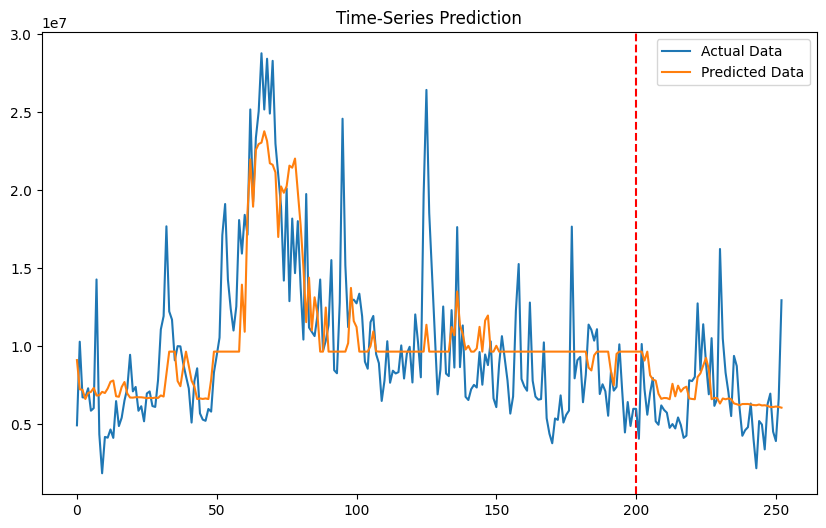

In [62]:
# 모델 예측 결과와 레이블 출력
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

- 그래프 상으로는 GRU가 LSTM 계층보다 예측력이 더 좋아보임. 수치상으로는 정확도 유사함.

### **7.7 양방향 RNN**

- 실제 문제에서는 과저 아닌 미래 시점의 데이터도 함께 활용해야 함. 양 시점의 데이터를 활용해 예측하는 것이 양방향 RNN

7.7.1 양방향 RNN 구조

- 하나의 출력 값을 예측하는데 메모리 셀 두 개 사용
  - 1-이전 시점의 은닉 상태 받아 현재 은닉 상태 계산
  - 2-다음 시점의 은닉 상태를 받아 현재 은닉 상채 계산
- GRU에도 적용됨

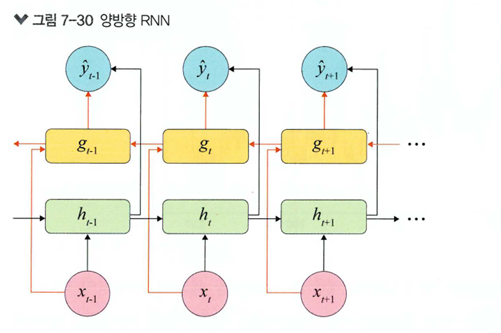

7.7.2 양방향 LSTM 구현

- LSTM 계층 코드와 동일하나 네트워크 부분이 다름
- 1. 계층 정의 부분(nn.LSTM)에서 bidirectional=True 사용: 양방향 LSTM/GRU 사용
  2. 한 번 학습에 두개의 계층이 필요--> 은닉상태, 셀 상태에 2를 곱하고 마지막 출력층에도 2를 곱함
    - hidden_size *2, self.num_layers *2

- 앞의 데이터로 모델 학습 결과, LSTM과 비교 시 예측 결과가 좋음. 데이터 유형별로 결과는 다를 수 있음

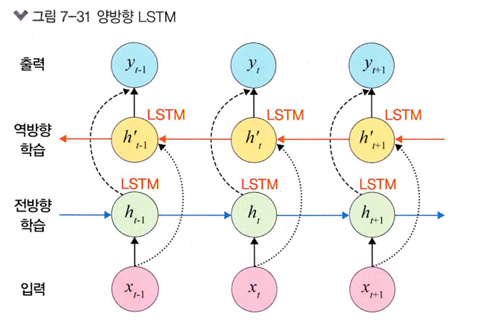

**데이터에 대한 전처리가 무엇보다 중요**

In [67]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

data = pd.read_csv('/content/drive/MyDrive/ESAA/OB 과제/SBUX.csv')
print(data.dtypes)

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Volume'] = data['Volume'].astype(float)

X = data.iloc[:, :-1]
y = data.iloc[:, 5:6]

ms = MinMaxScaler()
ss = StandardScaler()
X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]
y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0],
                                                    1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0],
                                                  1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [68]:
# 모델의 네트워크
class biLSTM(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(biLSTM, self).__init__()
    self.num_classes = num_classes
    self.num_layers = num_layers
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.seq_length = seq_length

    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                        num_layers=num_layers, bidirectional=True, batch_first=True) # 옵션 변경
    self.fc = nn.Linear(hidden_size*2, num_classes) # *2
    self.relu = nn.ReLU()

  def forward(self, x):
    h_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)) # *2
    c_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)) # *2
    out, _ = self.lstm(x, (h_0, c_0))
    out = self.fc(out[:, -1, :])
    out = self.relu(out)
    return out

In [69]:
# 모델 학습
num_epochs = 1000
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers = 1
num_classes = 1
model = biLSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
  outputs = model.forward(X_train_tensors_f)
  optimizer.zero_grad()

  loss = criterion(outputs, y_train_tensors)
  loss.backward()
  optimizer.step()
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.08537
Epoch: 100, loss: 0.07791
Epoch: 200, loss: 0.07116
Epoch: 300, loss: 0.06503
Epoch: 400, loss: 0.05943
Epoch: 500, loss: 0.05434
Epoch: 600, loss: 0.04975
Epoch: 700, loss: 0.04567
Epoch: 800, loss: 0.04212
Epoch: 900, loss: 0.03909


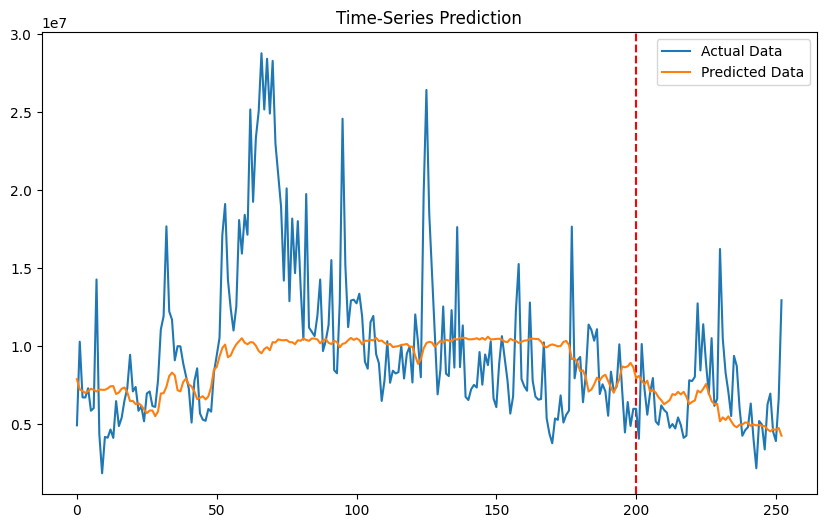

In [70]:
# 모델 평가
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()